# ***CSYE 7370 Deep Learning and Reinforcement Learning in Game Engineering*** 

 Student name :QIANG MA         
 NUID: 001057824

## Final Project: Solving the Navigation Problem with a Double Deep Q-Network (DDQN)
---
In this notebook, I train a DDQN agent to solve the navigation problem within the Udacity Deep Reinforcement
Learning Nanodegree.

final project github:https://github.com/qma16443/CSYE7370_final_project.git

### 1. Project Overview 
  In this project I plan to train an agent to pick up yellow bananas that are scattered throughout a square world. The agent must learn to navigate in its environment to reach yellow bananas (reward of +1 each) while avoiding collecting blue bananas (reward of -1 each). To solve this problem I am going to employ the Double Deep Q-Learning (DDQN) algorithm.


### 2. Environment Settings

My project will use rich simulation environments from Unity ML-Agents in the Deep Reinforcement Learning Nanodegree program.(https://github.com/udacity/deep-reinforcement-learning).

To set up your python environment to run the code, follow the instructions below.
1.	Create (and activate) a new environment with Python 3.6.

    o	Linux or Mac:
    
             conda create --name drlnd python=3.6
        
             source activate drlnd
        
    o	Windows:
    
             conda create --name drlnd python=3.6 
        
             activate drlnd
        
        
2. terminal:         
                                      
          pip install ipykernel

3. Create an IPython kernel for the drlnd environment.

          python -m ipykernel install --user --name drlnd --display-name "drlnd"
      
     
4. Before running code in a notebook, change the kernel to match the ‘drlnd’ environment by using the drop-down Kernel menu.
5. terminal: 

          pip install unityagents,torch,scipy
                 
7. I have download the unity file in the package ,if you want to update Banana.unity, go to this github source https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation

6. Follow the instructions in Navigation.ipynb to test the environment.


### 3. Unity Environment Description 

My project will use rich simulation environments from Unity ML-Agents in the Deep Reinforcement Learning Nanodegree program.
For this project, I will train an agent to navigate (and collect bananas) in a large, square world.
 
A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.
The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to: 

•	0 - move forward.

•	1 - move backward.

•	2 - turn left.

•	3 - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.


### 4. Learning Algorithm

To solve the environment as described before, I will use the Double Deep Q-Learning (DDQN) algorithm[1]. Briefly summarize the algorithm in the following. 

I will train the agent for a maximum of 2000 episodes or until the environment is solved, where an episode ends after 2000 time steps. In each time step the agent will interact with the environment according to an $\epsilon$
-greedy policy and receives an experience$E_i = (S_i^i,A_i^i,R_i+1^i,S_i+1^i)$ as well as the resulting reward and next state of the environment. Each experience tuple will be stored in the agents replay buffer, which can hold up to ***BUFFER_SIZE*** samples. after ***UPDATE_EVERY*** time steps, I am going to sample a batch ***E*** of ***BATCH_SIZE***experience tuples from the replay buffer and train the agent using this experience. 

For DDQN learning happens as follows. I will maintain two Q-Networks, the local and the target network, which I will use to approximate the state-action value function. In fact, I may simply maintain two sets of weights ($\theta^{local}$ and$ \theta^{target}$) for the same network architecture. I will then train the local network by minimizing the mean-squared error loss function.

$$
L(E)=\sum_{i=1}^{BATCH\_SIZE} (Y_i-\hat{Q}(S_i^2,A_i^i,\theta^{local}))^2
$$
   
where the targets $Y_i$ are given as

$$
Y_i = R_{i+1}^i+\Gamma \cdot \hat{Q}(S_{i+1}^i,\text{argmax}_a\hat{Q}(S_{t+1}^i,a,\theta^{local}),\theta^{target})
$$

using the Adam Optimizer with learning rate LR.

  After updating the local network, we perform a soft update of the target network towards the local network, i,e
  
$$\theta^{target}=(1-TAU)\theta^{target}+TAU\cdot\theta^{target}
$$

In my solution I set $\Gamma=TAU$

### 5.  Implementation

- ***Hyperparameter***

The hyper-parameters of my implementation are declared in the follow. I note that by reducing the discount factor GAMMA from 0.99 to 0.95 sped up training remarkably. As far as I am concerned that a more short-sighted, greedy behavior fits the given task very well, since no sophisticated strategy is required to pick up the bananas (e.g. move towards the closest yellow banana, avoid any blue bananas at any time step...).


   BATCH_SIZE = 32
   
   BUFFER_SIZE = $10^5$
   
   EPSILON DECAY = 1000
   
   EPSILON INIT = 1.0
   
   EPSILON MIN = 0.1
   
   GAMMA = 0.95
   
   LR = 5$\cdot 10^{-4}$
   
   TAU = 5$\cdot 10^{-2}$
   
   UPDATE_EVERY = 4

- ***Model Architecture***

The Q-Network architecture is defined in model.py. I use an architecture as follow:

    37 input neurons (i.e. the dimension of the state space), 
    Three fully-connected hidden layers with (64, 32, 16) neurons and ReLU activation functions, 
    A linear output layer of 4 neurons, one representing the state-action value of each possible action.

- ***$\epsilon$-greedy Policy***

                     p=random()
                     if p < $\epsilon$:
                         pull random action
                     else:
                         pull current-best action

During training I selected actions according to an $\epsilon$-greedy policy where we approximate the state-action values utilizing the local network. I initialize $\epsilon$ to ***EPSILON_INIT*** at the begin- ning of training. Then  linearly anneal $\epsilon$ to a value of ***EPSILON_MIN*** within ***EPSILON_DECAY*** episodes. In the experiments, I observed that linear annealing enables a significantly faster performance increase when compared to an exponential decay. I think that especially in early training steps, exploration decays too quickly in the latter case.

### 6.Lab

#### 1. Import the Necessary Packages
All my project code will be under working environment Python 3.6 environment along with the packages numpy, *scipy *, matplotlib, pytorch, and unityagents. Furthermore, the unity environment must be downloaded. 

In [2]:
from collections import deque
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import torch
from unityagents import UnityEnvironment

from ddqn_agent import Agent as DDQN_Agent
#package below only use for MAC
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### 2. Instantiate the Environment

Initialize the environment in the code cell below. **Change the unity environment path if necessary!**

In [3]:
# change path if necessary
env = UnityEnvironment(file_name="/Users/maqiang/Desktop/CSYE7370/Assignment/final/Banana.app")  

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of actions: 4
States have length: 37


#### 3. Instantiate and Train the DDQN Agent

Run the code cell below to instantiate and train the DDQN Agent

In [3]:
def train_agent(agent, n_episodes=2000, max_t=2000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        agent.adaptive_eps.update()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), './checkpoints/checkpoint_' + str(i_episode-100) +  '.pth')
            break
    return scores

agent = DDQN_Agent(state_size=state_size, action_size=action_size)
scores = train_agent(agent)

Episode 100	Average Score: 0.23
Episode 200	Average Score: 0.63
Episode 300	Average Score: 1.48
Episode 400	Average Score: 2.91
Episode 500	Average Score: 4.36
Episode 600	Average Score: 6.24
Episode 700	Average Score: 7.42
Episode 800	Average Score: 9.45
Episode 900	Average Score: 11.22
Episode 1000	Average Score: 12.97
Episode 1001	Average Score: 13.00
Environment solved in 901 episodes!	Average Score: 13.00


#### 4. Plot the training scores

I plot the training scores and a running average over 100 episodes in the next cell.

Text(0.5, 1.0, 'Evolution of the agents scores during training.')

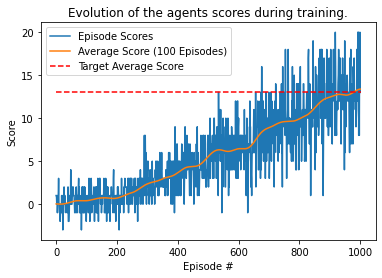

In [8]:
# compute running average score across 'win_size' episodes
win_size = 100
win = ss.windows.hann(win_size)
win /= np.sum(win)
padded_scores = np.append(scores, [scores[-1]]*(win_size-1))
smoothed_scores = ss.convolve(padded_scores, win, mode='same')[:len(scores)]

# plot the scores
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Episode Scores')
plt.plot(np.arange(len(smoothed_scores)), smoothed_scores, label='Average Score (100 Episodes)')
plt.plot([0, len(scores)], [13, 13], '--r', label='Target Average Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='best')
# plt.show()

plt.savefig('./img/scores.png', dpi=400)
plt.title('Evolution of the agents scores during training.')


The plot shows the DDQN agent was able to solve the environment after 901 episodes (the average score of episode 888 to 988 is greater of equal than +13). The corresponding model weights are stored in ./checkpoints/checkpoint 888.pth. 


#### 5. Watch a Smart Agent collecting Blue Bananas!

Load the trained weights from a file and watch the trained agent perform its task! 

In [4]:
# load the weights from file
agent = DDQN_Agent(state_size=state_size, action_size=action_size)
agent.qnetwork_local.load_state_dict(torch.load('./checkpoints/checkpoint_901.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for t in range(1000):
    action = agent.act(state, greedy=True)         # select an action greedily
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))


Score: 18.0


When Traing our agent, the environment plays as follow:

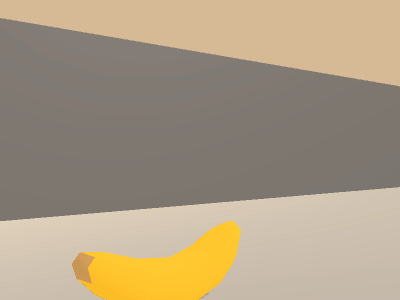

#### 6. Close the Environment

Close the environment if training and evaluation are finished.

In [6]:
env.close()

### 7. Ideas for Future Improvements

Since the final time is really limited, so I just implement very basic idea of DDQN. To further improve the learning time of the agent (assuming performance requirements in terms of return as satisfied), I would suggest the following extensions.

- ***Prioritized Experience Replay:*** 
In order to learn more efficiently it could help to employ Prioritized Experience Replay [3]. The key idea here is that experience tuples that yield a high training loss are more valuable for learning and hence should be sampled more frequently from the replay buffer.
- ***Dueling Deep Q-Networks:***
An easy-to-implement extension for the agent would be the implementation of a dueling architecture for the Q-networks as proposed in [4].

## Reference
[1] Van Hasselt, Hado, Arthur Guez, and David Silver. ”Deep reinforcement learning with double q-learning.” Thirtieth AAAI conference on artificial intelligence. 2016.

[2] Kingma, Diederik P., and Jimmy Ba. ”Adam: A method for stochastic optimization.” arXiv preprint arXiv:1412.6980 (2014).

[3] Schaul, Tom, et al. ”Prioritized experience replay.” arXiv preprint arXiv:1511.05952 (2015).

[4] Wang, Ziyu, et al. ”Dueling network architectures for deep reinforcement learning.” arXiv preprint arXiv:1511.06581 (2015).

## *License*

Copyright <2020> Qiang Ma<COPYRIGHT QIANG MA>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.